# Sentiment-Enhanced Stock Predictor — End-to-End Workflow

This notebook walks through the full MVP pipeline:

1. Setup & imports
2. Build dataset (prices + sentiment)
3. Feature engineering & target creation
4. EDA
5. Train LSTM models (per ticker)
6. Predict & conservative backtest
7. Visualize results & compute metrics

**Pre-reqs**
- Create `.env` with `NEWSAPI_KEY=...`
- Install requirements: `pip install -r requirements.txt`
- From repo root.


In [4]:
# Cell: Setup & imports
import os
import sys
import json
import datetime as dt
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent  # go up one directory
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# helper plotting defaults
plt.rcParams["figure.figsize"] = (10, 5)

# convenience utils
def show_df_head(df, n=5):
    display(df.head(n))

print("Working directory:", repo_root)


Working directory: /Users/abhirupghosh/Documents/Work/job_preparation/case_studies/sentiment-enhanced-stock-predictor


## Configuration: tickers, date range, model params
Set the assets and hyperparameters for the run below.

In [5]:
# Cell: configuration
TICKERS = ["AAPL", "MSFT", "NVDA"]          # start small for speed
START = "2023-01-01"
END = dt.date.today().isoformat()
FEATURES_PATH = "data/processed/features.parquet"
LOOKBACK = 10
EPOCHS = 8   # keep small for quick runs; increase later
THRESHOLD = 0.75
HOLD_DAYS = 3

print("Tickers:", TICKERS, "Start:", START, "End:", END)


Tickers: ['AAPL', 'MSFT', 'NVDA'] Start: 2023-01-01 End: 2025-09-04


# 1) Build dataset (prices + sentiment + features + targets)

This step:
- fetches prices (via `src.data_fetch.fetch_prices`)
- fetches headlines via NewsAPI and scores them with VADER (via `src.sentiment.get_daily_sentiment`)
- computes technical features (via `src.features.add_technical_features` + `merge_sentiment`)
- computes `future_return_3d` and `target`
- saves result to `data/processed/features.parquet`


In [8]:
# Cell: build dataset (calls src.build_dataset.main)
# We call the build_dataset main function to create features parquet.
from importlib import import_module
mod = import_module("src.build_dataset")
# mod.main(tickers, start, end, out_path)
mod.main(TICKERS, START, END, FEATURES_PATH)
print("Saved features to:", FEATURES_PATH)

/Users/abhirupghosh/Documents/Work/job_preparation/case_studies/sentiment-enhanced-stock-predictor/src/data_fetch.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=1).rename_axis(["Date","Ticker"]).reset_index()


Saved features to data/processed/features.parquet with shape (2007, 18)
Saved features to: data/processed/features.parquet


# Inspect the created features

In [9]:
# Cell: load features and quick check
df = pd.read_parquet(FEATURES_PATH)
print("Features shape:", df.shape)
print("Columns:", df.columns.tolist())
show_df_head(df)

Features shape: (2007, 18)
Columns: ['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return_1d', 'SMA_5', 'SMA_10', 'SMA_20', 'Vol_10', 'date', 'sentiment', 'ticker', 'sentiment_3d', 'future_return_3d', 'target']


,Date,Ticker,Close,High,Low,Open,Volume,Return_1d,SMA_5,SMA_10,SMA_20,Vol_10,date,sentiment,ticker,sentiment_3d,future_return_3d,target
0,2023-01-03,AAPL,123.330643,129.079559,122.443158,128.468186,112117500,NaN,NaN,NaN,NaN,NaN,2023-01-03,0.0,None,0.0,0.036380,1
1,2023-01-04,AAPL,124.602707,126.870724,123.340509,125.125335,89113600,0.010314,NaN,NaN,NaN,NaN,2023-01-04,0.0,None,0.0,0.029994,1
2,2023-01-05,AAPL,123.281342,125.993097,123.024963,125.361998,80962700,-0.010605,NaN,NaN,NaN,NaN,2023-01-05,0.0,None,0.0,0.045673,1
3,2023-01-06,AAPL,127.817360,128.478040,123.153145,124.257571,87754700,0.036794,NaN,NaN,NaN,NaN,2023-01-06,0.0,None,0.0,0.029857,1
4,2023-01-09,AAPL,128.339996,131.554669,128.083618,128.655553,70790800,0.004089,125.474409,NaN,NaN,NaN,2023-01-09,0.0,None,0.0,0.025048,1


# 2) EDA — price, returns, sentiment distributions, correlations

Do a basic exploratory analysis to ensure data quality.


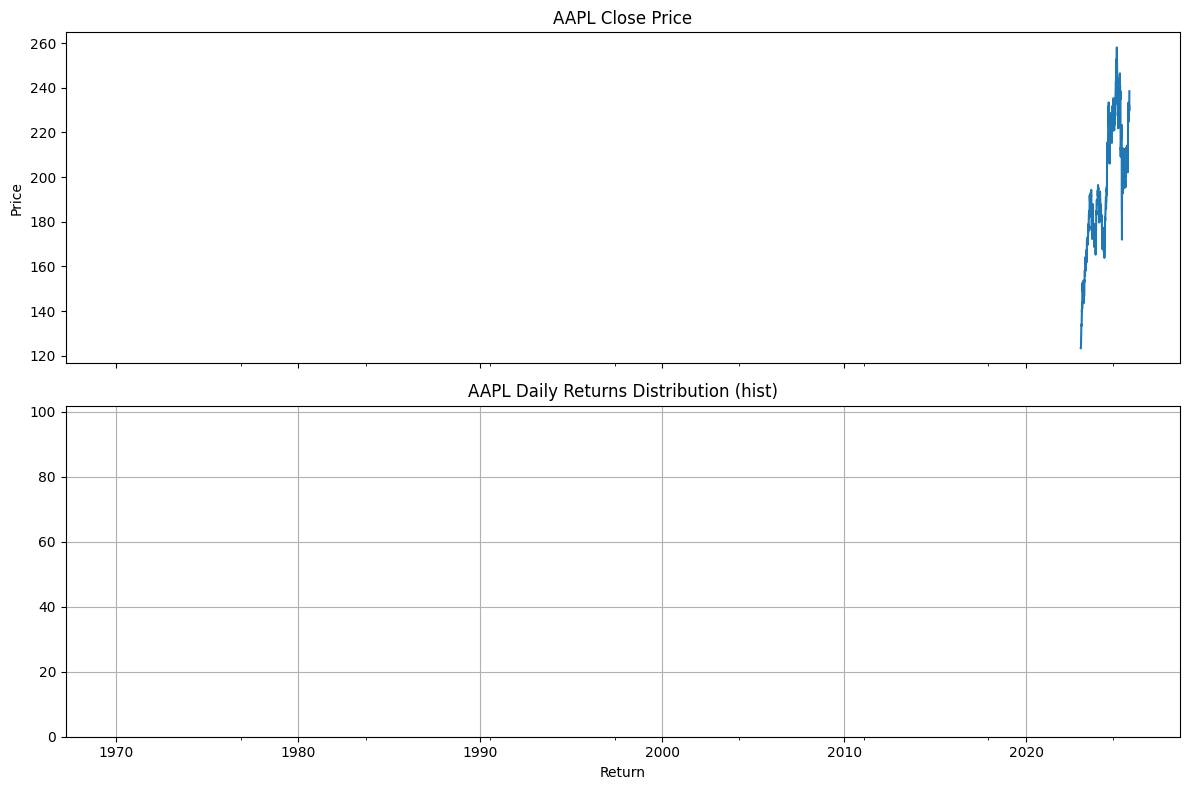

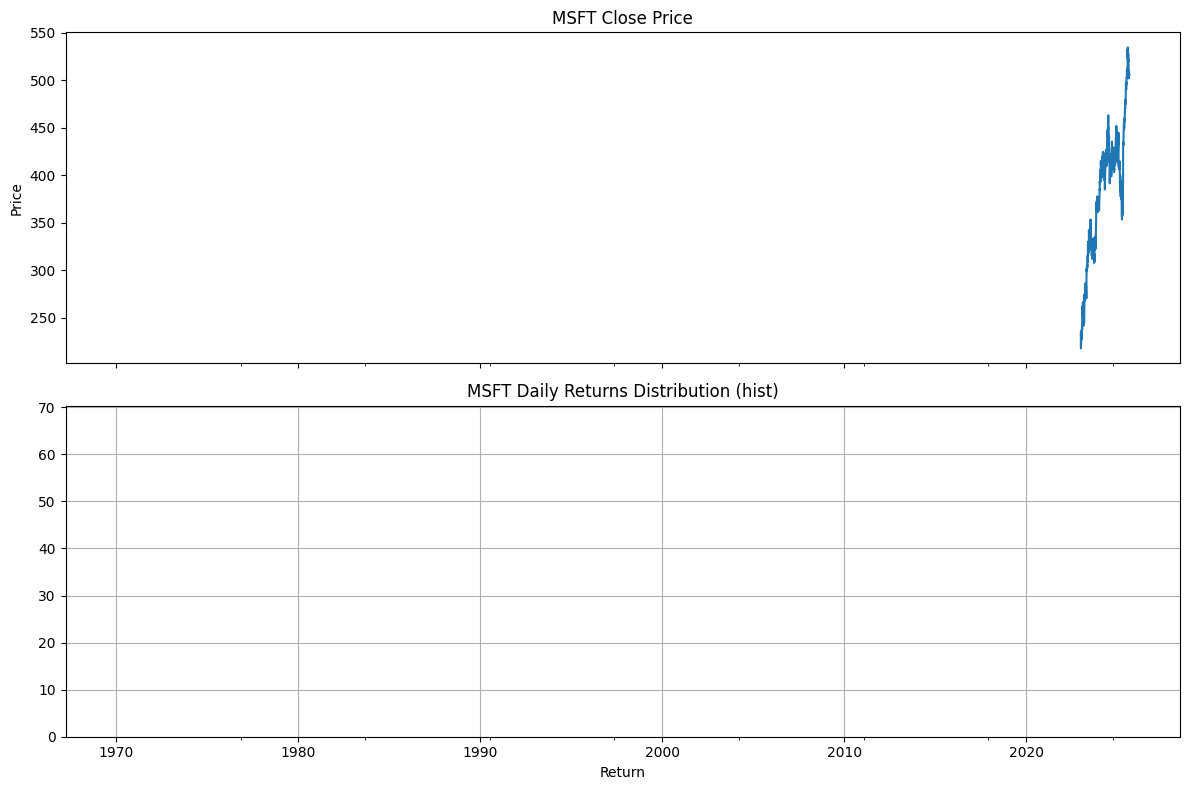

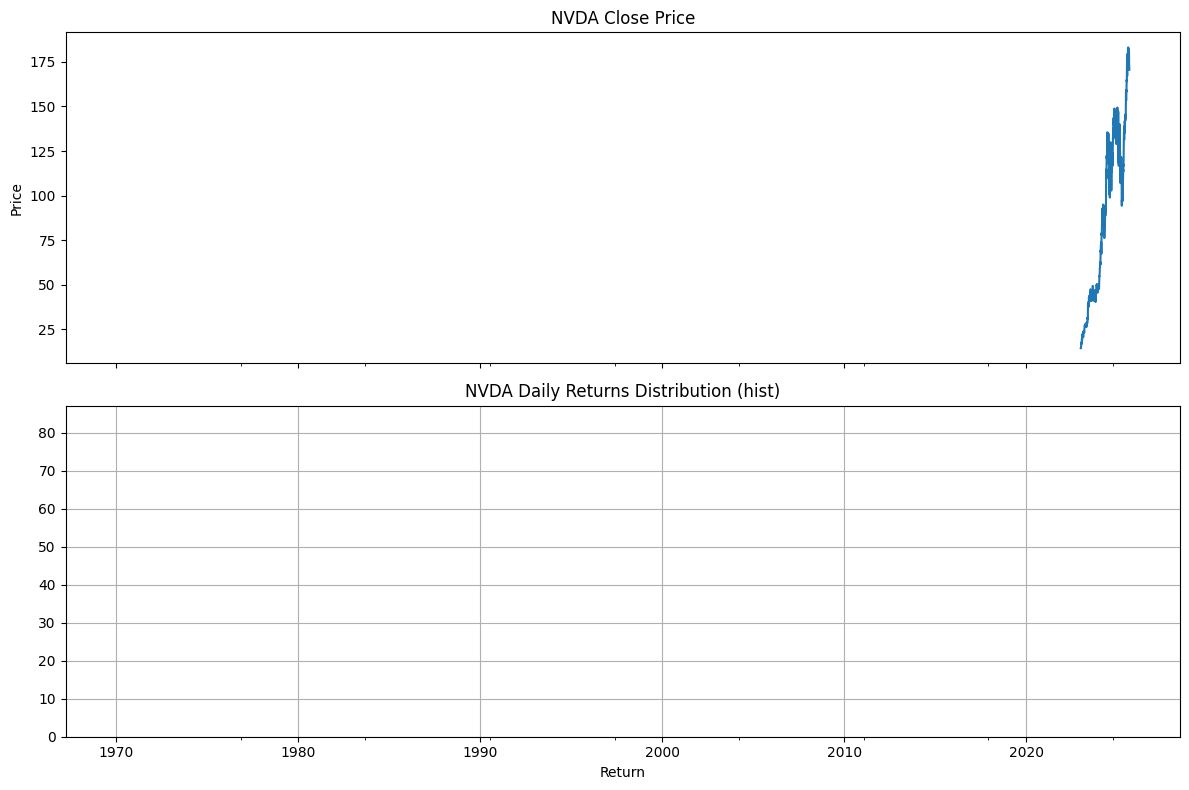

In [10]:
# Cell: EDA - price & returns per ticker
for t in TICKERS:
    d = df[df["Ticker"] == t].sort_values("Date").copy()
    d = d.set_index("Date")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    d["Close"].plot(ax=ax[0], title=f"{t} Close Price")
    ax[0].set_ylabel("Price")
    d["Return_1d"].hist(bins=60, ax=ax[1])
    ax[1].set_title(f"{t} Daily Returns Distribution (hist)")
    ax[1].set_xlabel("Return")
    plt.tight_layout()
    plt.show()



Ticker AAPL — sentiment summary:


,Date,sentiment,sentiment_3d
0,2023-01-03,0.0,0.0
1,2023-01-04,0.0,0.0
2,2023-01-05,0.0,0.0
3,2023-01-06,0.0,0.0
4,2023-01-09,0.0,0.0
5,2023-01-10,0.0,0.0


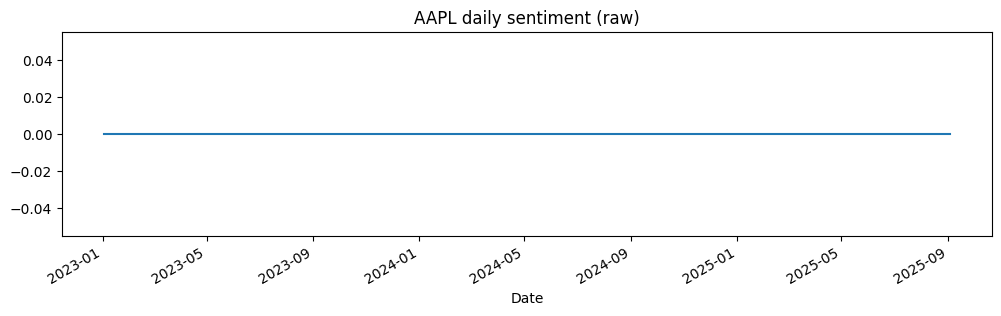


Ticker MSFT — sentiment summary:


,Date,sentiment,sentiment_3d
669,2023-01-03,0.0,0.0
670,2023-01-04,0.0,0.0
671,2023-01-05,0.0,0.0
672,2023-01-06,0.0,0.0
673,2023-01-09,0.0,0.0
674,2023-01-10,0.0,0.0


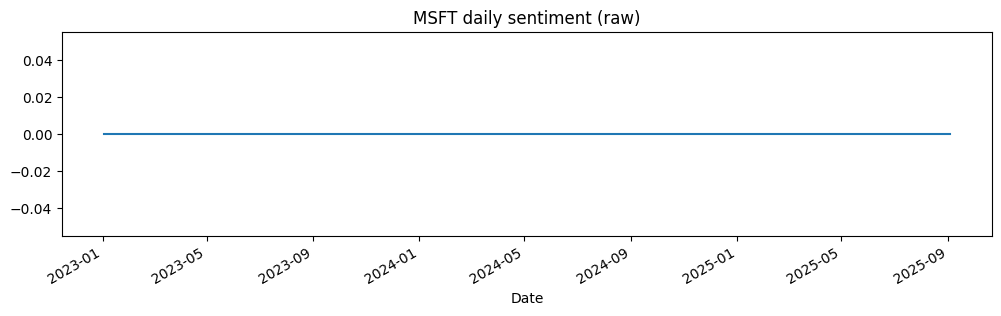


Ticker NVDA — sentiment summary:


,Date,sentiment,sentiment_3d
1338,2023-01-03,0.0,0.0
1339,2023-01-04,0.0,0.0
1340,2023-01-05,0.0,0.0
1341,2023-01-06,0.0,0.0
1342,2023-01-09,0.0,0.0
1343,2023-01-10,0.0,0.0


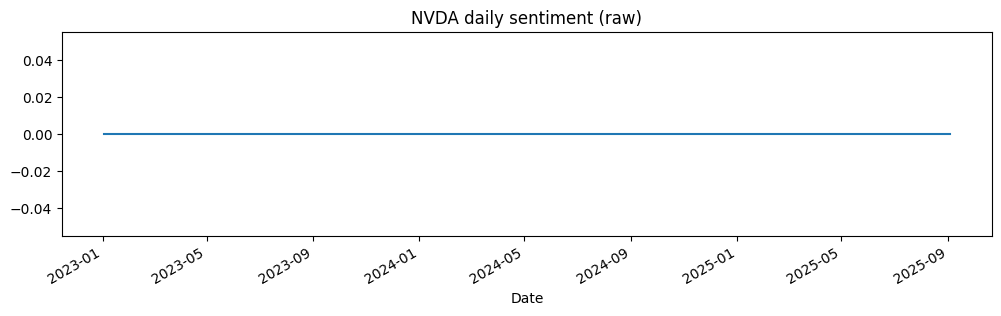

In [11]:
# Cell: sentiment distribution and rolling sentiment
for t in TICKERS:
    d = df[df["Ticker"] == t].sort_values("Date").copy()
    if "sentiment" in d.columns:
        print(f"\nTicker {t} — sentiment summary:")
        display(d[["Date","sentiment","sentiment_3d"]].dropna().head(6))
        d.set_index("Date")["sentiment"].plot(title=f"{t} daily sentiment (raw)", figsize=(12,3))
        plt.show()
    else:
        print(f"No sentiment column for {t} (this can happen if no headlines were found)")


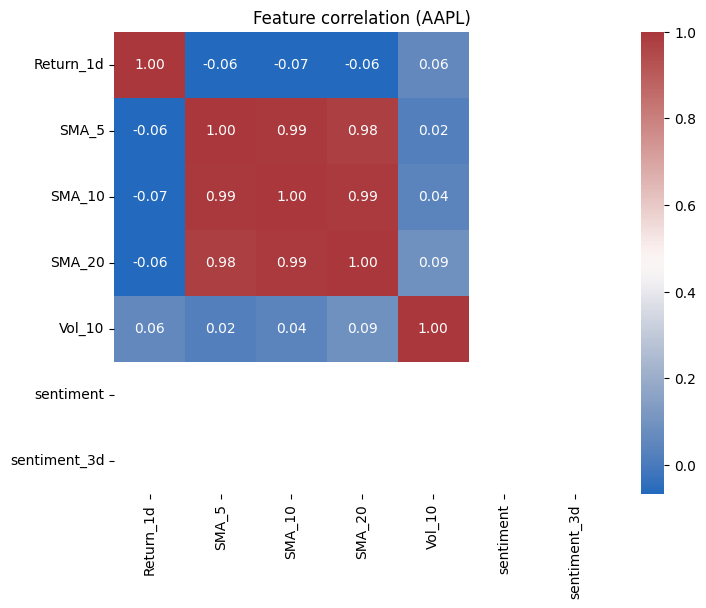

In [14]:
# Cell: correlation heatmap among numeric features (sample ticker)
import seaborn as sns
sample = df[df["Ticker"]==TICKERS[0]].dropna(subset=["Return_1d","SMA_5","SMA_10","SMA_20","Vol_10","sentiment","sentiment_3d"])
corr = sample[["Return_1d","SMA_5","SMA_10","SMA_20","Vol_10","sentiment","sentiment_3d"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title(f"Feature correlation ({TICKERS[0]})")
plt.show()


# 3) Target distribution

Check how many positive (up in next 3 days) vs negative examples we have.


In [15]:
# Cell: target distribution
for t in TICKERS:
    d = df[df["Ticker"]==t]
    if "target" in d.columns:
        counts = d["target"].value_counts(dropna=True).to_dict()
        print(f"{t} target counts:", counts)
    else:
        print(f"{t} has no 'target' column.")


AAPL target counts: {1: 387, 0: 282}
MSFT target counts: {1: 389, 0: 280}
NVDA target counts: {1: 409, 0: 260}


# 4) Train LSTM models per ticker

This runs `src.train.main` which trains a model per ticker (80/20 time split), saves models, scalers and metrics to `reports/`.


In [16]:
# Cell: training (calls src.train.main)
train_mod = import_module("src.train")
train_mod.main(FEATURES_PATH, out_models="models", reports_dir="reports", lookback=LOOKBACK, epochs=EPOCHS)
print("Training finished. Check reports/ for metrics JSONs.")


[AAPL] {'accuracy': 0.5666666666666667, 'precision': 0.5666666666666667, 'recall': 1.0, 'auc': 0.4686085972850679, 'n_val': 120}
[MSFT] {'accuracy': 0.6, 'precision': 0.6, 'recall': 1.0, 'auc': 0.5616319444444444, 'n_val': 120}
[NVDA] {'accuracy': 0.38333333333333336, 'precision': 0.6363636363636364, 'recall': 0.09090909090909091, 'auc': 0.4651162790697675, 'n_val': 120}
Training finished. Check reports/ for metrics JSONs.


# Inspect training metrics

In [17]:
# Cell: print metrics summary
summary_path = Path("reports/summary.json")
if summary_path.exists():
    with open(summary_path, "r") as f:
        summary = json.load(f)
    print(json.dumps(summary, indent=2))
else:
    print("No summary.json found. Check reports/ for individual ticker metrics files.")


{
  "AAPL": {
    "accuracy": 0.5666666666666667,
    "precision": 0.5666666666666667,
    "recall": 1.0,
    "auc": 0.4686085972850679,
    "n_val": 120
  },
  "MSFT": {
    "accuracy": 0.6,
    "precision": 0.6,
    "recall": 1.0,
    "auc": 0.5616319444444444,
    "n_val": 120
  },
  "NVDA": {
    "accuracy": 0.38333333333333336,
    "precision": 0.6363636363636364,
    "recall": 0.09090909090909091,
    "auc": 0.4651162790697675,
    "n_val": 120
  }
}


# 5) Predict on holdout & run conservative backtest

This runs `src.predict_and_backtest.main` which creates per-ticker `reports/{TICKER}_predictions.csv` and `reports/{TICKER}_equity.csv`.


In [18]:
# Cell: predict & backtest
predmod = import_module("src.predict_and_backtest")
predmod.main(FEATURES_PATH, models_dir="models", reports_dir="reports", lookback=LOOKBACK, threshold=THRESHOLD, hold_days=HOLD_DAYS)
print("Predictions & backtests saved to reports/")


[AAPL] predictions & equity saved.
[MSFT] predictions & equity saved.
[NVDA] predictions & equity saved.
Predictions & backtests saved to reports/


# 6) Visualize predictions & equity curves

Plot the predicted probability over time, sample trades, and equity curve for a selected ticker.


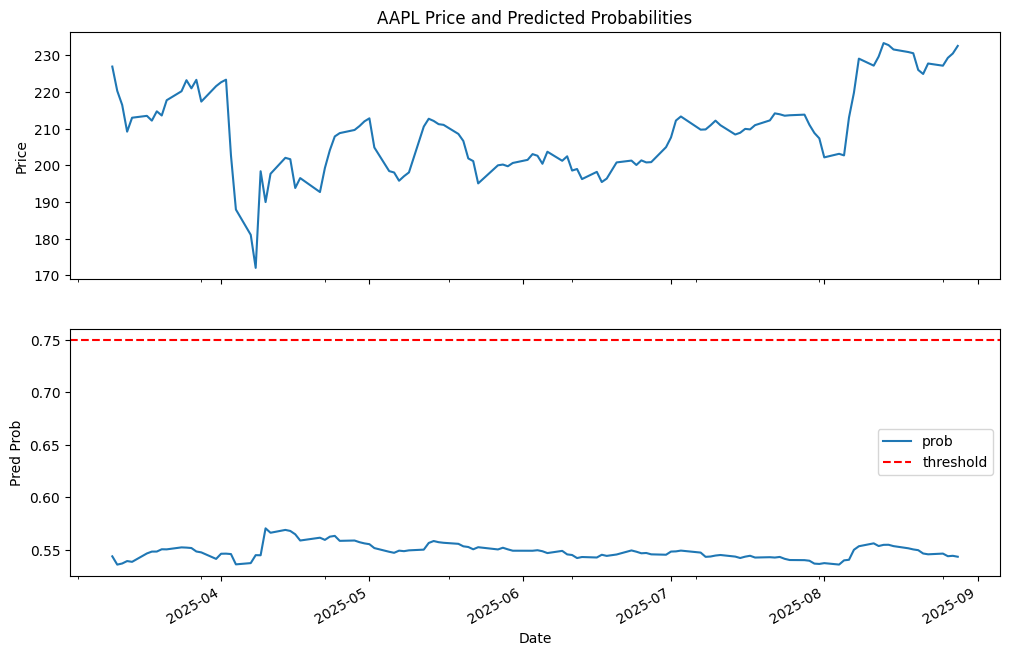

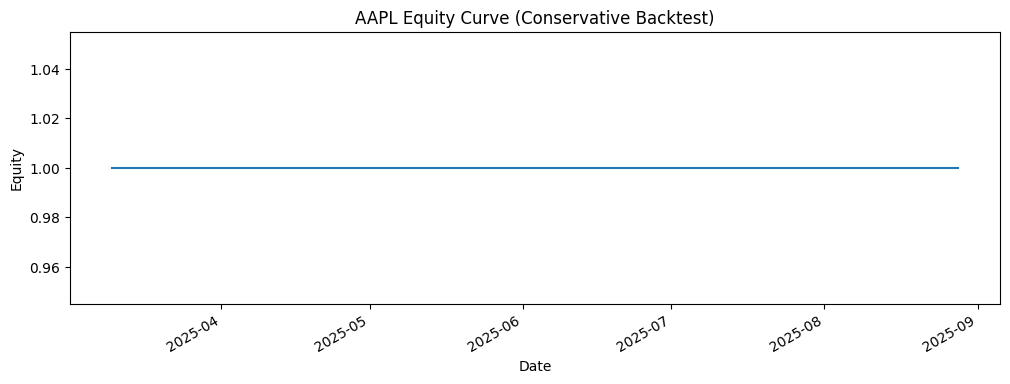

,Date,Ticker,Close,prob,future_return_3d
110,2025-08-15,AAPL,231.589996,0.553264,-0.024094
111,2025-08-18,AAPL,230.889999,0.551192,-0.025943
112,2025-08-19,AAPL,230.559998,0.550117,-0.012144
113,2025-08-20,AAPL,226.009995,0.549396,0.005088
114,2025-08-21,AAPL,224.899994,0.546231,0.019609
115,2025-08-22,AAPL,227.759995,0.545453,0.011986
116,2025-08-25,AAPL,227.160004,0.546129,0.023772
117,2025-08-26,AAPL,229.309998,0.543640,0.012341
118,2025-08-27,AAPL,230.490005,0.544017,-0.003341
119,2025-08-28,AAPL,232.559998,0.543133,0.025413


In [19]:
# Cell: load a ticker's prediction and equity, visualize
selected = TICKERS[0]  # change as desired
pred_path = Path(f"reports/{selected}_predictions.csv")
equity_path = Path(f"reports/{selected}_equity.csv")

if pred_path.exists() and equity_path.exists():
    pred_df = pd.read_csv(pred_path, parse_dates=["Date"])
    eq_df = pd.read_csv(equity_path, parse_dates=["Date"])
    pred_df = pred_df.sort_values("Date").reset_index(drop=True)
    eq_df = eq_df.sort_values("Date").reset_index(drop=True)

    # Price + prob
    fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
    pred_df.set_index("Date")["Close"].plot(ax=ax[0], title=f"{selected} Price and Predicted Probabilities")
    ax[0].set_ylabel("Price")
    pred_df.set_index("Date")["prob"].plot(ax=ax[1], kind="line")
    ax[1].axhline(THRESHOLD, color="red", linestyle="--", label="threshold")
    ax[1].set_ylabel("Pred Prob")
    ax[1].legend()
    plt.show()

    # equity curve
    eq_df.set_index("Date")["equity"].plot(title=f"{selected} Equity Curve (Conservative Backtest)", figsize=(12,4))
    plt.ylabel("Equity")
    plt.show()

    # sample last trades
    display(pred_df[["Date","Ticker","Close","prob","future_return_3d"]].tail(10))
else:
    print("Predictions or equity file not found for", selected)


# 7) Compute backtest metrics: CAGR, annualized volatility, Sharpe, max drawdown, win rate

Note: the equity curve produced here is simplistic: trades are simulated sequentially using the conservative rule.


In [21]:
# Cell: compute metrics helper functions
import math

def compute_cagr(equity_series, periods_per_year=252):
    # equity_series is a pandas Series indexed by date or integer with cumulative equity values
    n = len(equity_series)
    if n < 2:
        return None
    start_val = float(equity_series.iloc[0])
    end_val = float(equity_series.iloc[-1])
    years = n / periods_per_year
    if start_val <= 0 or years <= 0:
        return None
    return (end_val / start_val) ** (1/years) - 1

def max_drawdown(equity_series):
    roll_max = equity_series.cummax()
    drawdown = equity_series / roll_max - 1.0
    return drawdown.min()

def annualized_vol(returns, periods_per_year=252):
    return returns.std() * (periods_per_year ** 0.5)

# compute using equity series if avail
if pred_path.exists() and equity_path.exists():
    eq = eq_df.set_index("Date")["equity"].dropna()
    cagr = compute_cagr(eq, periods_per_year=252)
    # compute daily returns from equity
    eq_returns = eq.pct_change().dropna()
    ann_vol = annualized_vol(eq_returns)
    sharpe = (cagr / ann_vol) if (cagr is not None and ann_vol and ann_vol > 0) else None
    mdd = max_drawdown(eq)
    print(f"CAGR (approx): {cagr:.2%}" if cagr is not None else "CAGR: N/A")
    print(f"Annualized vol (approx): {ann_vol:.2%}" if ann_vol is not None else "Vol: N/A")
    print(f"Sharpe (approx): {sharpe:.2f}" if sharpe is not None else "Sharpe: N/A")
    print(f"Max drawdown: {mdd:.2%}" if mdd is not None else "Max drawdown: N/A")
else:
    print("Equity curve not available to compute metrics.")


CAGR (approx): 0.00%
Annualized vol (approx): 0.00%
Sharpe: N/A
Max drawdown: 0.00%


# 8) Quick checklist & next actions

- If the sentiment column is sparse, consider:
  - Increasing `max_pages` in `src.sentiment.fetch_newsapi_headlines`
  - Using alternate sources (Twitter, Yahoo headlines)
  - Using FinBERT for more domain-specific sentiment

- To improve modeling:
  - Increase `EPOCHS` and `LOOKBACK`
  - Add dropout / early stopping
  - Expand feature set (ATR, MACD, volume spikes)
  - Try attention / transformer encoders for time series

- Deployment:
  - Use the Streamlit app `app/dashboard.py` to display predictions after `predict_and_backtest` produces CSVs.
  - Add a scheduled job (cron) to re-run data build → train → predict on a cadence (e.g., weekly).


# Save & finish

If you want to persist artifacts or produce a report, save the key files:
- `data/processed/features.parquet`
- `models/`
- `reports/`
